In [1]:
# setup Pytorch env
import os
os.environ['TORCH_HOME']="/home/alex/data/pytorch"

from matplotlib import pyplot as plt

import torchvision as torchv
import torch as torch
import PIL as pil
import math

# 06. Using a neural network to fit the data
So far, we’ve taken a close look at how a linear model can learn and how to make that happen in `PyTorch`. We’ve focused on a very simple regression problem that used a linear model with only one input and one output. Such a simple example allowed us to dissect the mechanics of a model that learns, without getting overly distracted by the implementation of the model itself. As we saw in the overview diagram in `chapter 5`, `figure 5.2` (repeated here as `figure 6.1`), the exact details of a model are not needed to understand the high-level process that trains the model. Backpropagating errors to parameters and then updating those parameters by taking the gradient with respect to the loss is the same no matter what the underlying model is.

<img src="images/05_02.png" style="width:600px;"/>

In this chapter, we will make some changes to our model architecture: we’re going to implement a full artificial neural network to solve our temperature-conversion problem. We’ll continue using our training loop from the last chapter, along with our `Fahrenheit-to-Celsius` samples split into training and validation sets. We could start to use a quadratic model: rewriting model as a quadratic function of its input (for example, $y = a*x^2 + b*x + c$). Since such a model would be differentiable, `PyTorch` would take care of computing gradients, and the training loop would work as usual. That wouldn’t be too interesting for us, though, because we would still be fixing the shape of the function.

This is the chapter where we begin to hook together the foundational work we’ve put in and the `PyTorch` features you’ll be using day in and day out as you work on your projects. You’ll gain an understanding of what’s going on underneath the porcelain of the `PyTorch` API, rather than it just being so much black magic. Before we get into the implementation of our new model, though, let’s cover what we mean by artificial neural network.

## 6.1 Artificial neurons
At the core of deep learning are neural networks: mathematical entities capable of representing complicated functions through a composition of simpler functions. 

The basic building block of these complicated functions is the `neuron`, as illustrated in `figure 6.2`. At its core, it is nothing but a linear transformation of the input (for example, multiplying the input by a number (the weight) and adding a constant (the bias)) followed by the application of a fixed nonlinear function (referred to as the *activation function8).

<img src="images/06_02.png" style="width:500px;"/>

Mathematically, we can write this out as $o = f(w * x + b)$, with $x$ as our input, $w$ our weight or scaling factor, and $b$ as our bias or offset. $f$ is our activation function, set to the hyperbolic tangent, or $tanh$ function here. In general, $x$ and, hence, $o$ can be simple scalars, or vector-valued (meaning holding many scalar values); and similarly, $w$ can be a single scalar or matrix, while $b$ is a scalar or vector (the dimensionality of the inputs and weights must match, however). In the latter case, the previous expression is referred to as a layer of neurons, since it represents many neurons via the multidimensional weights and biases.

### 6.1.1 Composing a multilayer network
A multilayer neural network, as represented in `figure 6.3`, is made up of a composition of functions like those we just discussed:

\begin{align} 
x_1 = f(w_0 * x + b_0) \\
x_2 = f(w_1 * x_1 + b_1) \\ 
... \\
y = f(w_n * x_n + b_n)
\end{align}

where the output of a layer of neurons is used as an input for the following layer. Remember that $w\_0$ here is a matrix, and $x$ is a vector! Using a vector allows $w\_0$ to hold an entire layer of neurons, not just a single weight.

<img src="images/06_03.png" style="width:600px;"/>

### 6.1.2 Understanding the error function
An important difference between our earlier linear model and what we’ll actually be using for deep learning is the shape of the error function. Our linear model and error-squared loss function had a convex error curve with a singular, clearly defined minimum. If we were to use other methods, we could solve for the parameters minimizing the error function automatically and definitively. That means that our parameter updates were attempting to estimate that singular correct answer as best they could.

Neural networks do not have that same property of a convex error surface, even when using the same error-squared loss function! There’s no single right answer for each parameter we’re attempting to approximate. Instead, we are trying to get all of the parameters, when acting in concert, to produce a useful output. Since that useful output is only going to approximate the truth, there will be some level of imperfection. Where and how imperfections manifest is somewhat arbitrary, and by implication the parameters that control the output (and, hence, the imperfections) are somewhat arbitrary as well. This results in neural network training looking very much like parameter estimation from a mechanical perspective, but we must remember that the theoretical underpinnings are quite different.

A big part of the reason neural networks have non-convex error surfaces is due to the activation function. The ability of an ensemble of neurons to approximate a very wide range of useful functions depends on the combination of the linear and nonlinear behavior inherent to each neuron.

### 6.1.3 All we need is activation
As we have seen, the simplest unit in (deep) neural networks is a linear operation (scaling + offset) followed by an activation function. We already had our linear operation in our latest model—the linear operation was the entire model. The activation function plays two important roles:

+ In the inner parts of the model, it allows the output function to have different slopes at different values—something a linear function by definition cannot do. By trickily composing these differently sloped parts for many outputs, neural networks can approximate arbitrary functions. 

+ At the last layer of the network, it has the role of concentrating the outputs of the preceding linear operation into a given range.

Let’s talk about what the second point means. Pretend that we’re assigning a "good doggo" score to images. Pictures of retrievers and spaniels should have a high score, while images of airplanes and garbage trucks should have a low score. Bear pictures should have a lowish score, too, although higher than garbage trucks.

The problem is, we have to define a "high score": we’ve got the entire range of float32 to work with, and that means we can go pretty high. Even if we say "it’s a $10$-point scale", there’s still the issue that sometimes our model is going to produce a score of $11$ out of $10$. Remember that under the hood, it’s all sums of $(w*x+b)$ matrix multiplications, and those won’t naturally limit themselves to a specific range of outputs.

<img src="images/06_04.png" style="width:600px;"/>

This results in garbage trucks being flagged as "not dogs", our good dog mapping to "clearly a dog", and our bear ending up somewhere in the middle. In code, we can see the exact values:

In [2]:
# Garbage truck, Bear, Good doggo
math.tanh(-2.2), math.tanh(0.1), math.tanh(2.5)

(-0.9757431300314515, 0.09966799462495582, 0.9866142981514303)

With the bear in the sensitive range, small changes to the bear will result in a noticeable change to the result. For example, we could switch from a grizzly to a polar bear (which has a vaguely more traditionally canine face) and see a jump up the $Y$-axis as we slide toward the "very much a dog" end of the graph. Conversely, a koala bear would register as less dog-like, and we would see a drop in the activated output. There isn’t much we could do to the garbage truck to make it register as dog-like, though: even with drastic changes, we might only see a shift from $–0.97$ to $–0.8$ or so.

### 6.1.4 More activation functions
There are quite a few activation functions, some of which are shown in `figure 6.5`. In the first column, we see the smooth functions `Tanh` and `Softplus`, while the second column has "hard" versions of the activation functions to their left: `Hardtanh` and `ReLU`. `ReLU` (for `rectified linear unit`) deserves special note, as it is currently considered one of the best-performing general activation functions; many state-of-the-art results have used it. The `Sigmoid` activation function, also known as the `logistic` function, was widely used in early deep learning work but has since fallen out of common use except where we explicitly want to move to the $0\sim1$ range: for example, when the output should be a probability. Finally, the `LeakyReLU` function modifies the standard `ReLU` to have a small positive slope, rather than being strictly zero for negative inputs (typically this slope is $0.01$, but it’s shown here with slope $0.1$ for clarity).

<img src="images/06_05.png" style="width:600px;"/>

### 6.1.5 Choosing the best activation function
Activation functions are curious, because with such a wide variety of proven successful ones (many more than shown in `figure 6.5`), it’s clear that there are few, if any, strict requirements. As such, we’re going to discuss some generalities about activation functions that can probably be trivially disproved in the specific. That said, by definition, activation functions

+ Are nonlinear. Repeated applications of $(w*x+b)$ without an activation function results in a function of the same (affine linear) form. The nonlinearity allows the overall network to approximate more complex functions.

+ Are differentiable, so that gradients can be computed through them. Point discontinuities, as we can see in `Hardtanh` or `ReLU`, are fine.

Without these characteristics, the network either falls back to being a linear model or becomes difficult to train.

The following are true for the functions:

+ They have at least one sensitive range, where nontrivial changes to the input result in a corresponding nontrivial change to the output. This is needed for training.

+ Many of them have an insensitive (or saturated) range, where changes to the input result in little or no change to the output.

By way of example, the `Hardtanh` function could easily be used to make piecewise-linear approximations of a function by combining the sensitive range with different weights and biases on the input.

Often (but far from universally so), the activation function will have at least one of these:

+ A lower bound that is approached (or met) as the input goes to negative infinity 

+ A similar-but-inverse upper bound for positive infinity

Thinking of what we know about how backpropagation works, we can figure out that the errors will propagate backward through the activation more effectively when the inputs are in the response range, while errors will not greatly affect neurons for which the input is saturated (since the gradient will be close to zero, due to the flat area around the output).

Put together, all this results in a pretty powerful mechanism: we’re saying that in a network built out of linear + activation units, when different inputs are presented to the network:

+ (a) different units will respond in different ranges for the same inputs

+ (b) the errors associated with those inputs will primarily affect the neurons operating in the sensitive range, leaving other units more or less unaffected by the learning process

In addition, thanks to the fact that derivatives of the activation with respect to its inputs are often close to 1 in the sensitive range, estimating the parameters of the linear transformation through gradient descent for the units that operate in that range will look a lot like the linear fit we have seen previously.

We are starting to get a deeper intuition for how joining many linear + activation units in parallel and stacking them one after the other leads us to a mathematical object that is capable of approximating complicated functions. Different combinations of units will respond to inputs in different ranges, and those parameters for those units are relatively easy to optimize through gradient descent, since learning will behave a lot like that of a linear function until the output saturates.

### 6.1.6 What learning means for a neural network
Building models out of stacks of linear transformations followed by differentiable activations leads to models that can approximate highly nonlinear processes and whose parameters we can estimate surprisingly well through gradient descent. This remains true even when dealing with models with millions of parameters. What makes using deep neural networks so attractive is that it saves us from worrying too much about the exact function that represents our data—whether it is quadratic, piecewise polynomial, or something else. With a deep neural network model, we have a universal approximator and a method to estimate its parameters. This approximator can be customized to our needs, in terms of model capacity and its ability to model complicated input/output relationships, just by composing simple building blocks. We can see some examples of this in `figure 6.6`.

<img src="images/06_06.png" style="width:600px;"/>

The four upper-left graphs show four neurons—$A$, $B$, $C$, and $D$—each with its own (arbitrarily chosen) weight and bias. Each neuron uses the `Tanh` activation function with a min of $–1$ and a max of $1$. The varied weights and biases move the center point and change how drastically the transition from min to max happens, but they clearly all have the same general shape. The columns to the right of those show both pairs of neurons added together ($A + B$ and then $C + D$). Here, we start to see some interesting properties that mimic a single layer of neurons. $A + B$ shows a slight $S$ curve, with the extremes approaching $0$, but both a positive bump and a negative bump in the middle. Conversely, $C + D$ has only a large positive bump, which peaks at a higher value than our single-neuron max of $1$.

In the third row, we begin to compose our neurons as they would be in a two-layer network. Both $C(A + B)$ and $D(A + B)$ have the same positive and negative bumps that $A + B$ shows, but the positive peak is more subtle. The composition of $C(A + B) + D(A + B)$ shows a new property: two clearly negative bumps, and possibly a very subtle second positive peak as well, to the left of the main area of interest. All this with only four neurons in two layers!

Again, these neurons’ parameters were chosen only to have a visually interesting result. Training consists of finding acceptable values for these weights and biases so that the resulting network correctly carries out a task, such as predicting likely temperatures given geographic coordinates and time of the year. By carrying out a task successfully, we mean obtaining a correct output on unseen data produced by the same data-generating process used for training data. A successfully trained network, through the values of its weights and biases, will capture the inherent structure of the data in the form of meaningful numerical representations that work correctly for previously unseen data.

Let’s take another step in our realization of the mechanics of learning: deep neural networks give us the ability to approximate highly nonlinear phenomena without having an explicit model for them. Instead, starting from a generic, untrained model, we specialize it on a task by providing it with a set of inputs and outputs and a loss function from which to backpropagate. Specializing a generic model to a task using examples is what we refer to as learning, because the model wasn’t built with that specific task in mind—no rules describing how that task worked were encoded in the model.

For our thermometer example, we assumed that both thermometers measured temperatures linearly. That assumption is where we implicitly encoded a rule for our task: we hardcoded the shape of our input/output function; we couldn’t have approximated anything other than data points sitting around a line. As the dimensionality of a problem grows (that is, many inputs to many outputs) and input/output relationships get complicated, assuming a shape for the input/output function is unlikely to work. The job of a physicist or an applied mathematician is often to come up with a functional description of a phenomenon from first principles, so that we can estimate the unknown parameters from measurements and get an accurate model of the world. Deep neural networks, on the other hand, are families of functions that have the ability to approximate a wide range of input/output relationships without necessarily requiring us to come up with an explanatory model of a phenomenon. In a way, we’re renouncing an explanation in exchange for the possibility of tackling increasingly complicated problems. In another way, we sometimes lack the ability, information, or computational resources to build an explicit model of what we’re presented with, so data-driven methods are our only way forward.

## 6.2 The PyTorch nn module
All this talking about neural networks is probably making you really curious about building one from scratch with `PyTorch`. Our first step will be to replace our linear model with a neural network unit. This will be a somewhat useless step backward from a correctness perspective, since we’ve already verified that our calibration only required a linear function, but it will still be instrumental for starting on a sufficiently simple problem and scaling up later.

`PyTorch` has a whole submodule dedicated to neural networks, called `torch.nn`. It contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called `modules` in `PyTorch` parlance (such building blocks are often referred to as `layers` in other frameworks). A `PyTorch` module is a Python class deriving from the `nn.Module` base class. A module can have one or more `Parameter` instances as attributes, which are tensors whose values are optimized during the training process (think $w$ and $b$ in our linear model). A module can also have one or more submodules (subclasses of `nn.Module`) as attributes, and it will be able to track their parameters as well.

> **NOTE**
> 
> The submodules must be top-level attributes, not buried inside list or dict instances! Otherwise, the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model requires a list or dict of submodules, `PyTorch` provides `nn.ModuleList` and `nn.ModuleDict`.

Unsurprisingly, we can find a subclass of `nn.Module` called `nn.Linear`, which applies an affine transformation to its input (via the parameter attributes weight and bias) and is equivalent to what we implemented earlier in our thermometer experiments. We’ll now start precisely where we left off and convert our previous code to a form that uses `nn`.

### 6.2.1 Using `__call__` rather than forward

All `PyTorch`-provided subclasses of `nn.Module` have their `__call__` method defined. This allows us to instantiate an `nn.Linear` and call it as if it was a function, like so:

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [4]:
linear_model = torch.nn.Linear(1, 1) 
linear_model(t_un_val)

tensor([[-1.2943],
        [-0.6388]], grad_fn=<AddmmBackward>)

Calling an instance of `nn.Module` with a set of arguments ends up calling a method named `forward` with the same arguments. The `forward` method is what executes the forward computation, while `__call__` does other rather important chores before and after calling `forward`. So, it is technically possible to call `forward` directly, and it will produce the same output as `__call__`, but this should not be done from user code:

<img src="images/c_06_01.png" style="width:600px;"/>

Here’s the implementation of `Module._call_` (we left out the bits related to the JIT and made some simplifications for clarity; `torch/nn/modules/module.py`, line 483`):

```python
def __call__(self, *input, **kwargs):
    for hook in self._forward_pre_hooks.values():
        hook(self, input)

    result = self.forward(*input, **kwargs)
    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
    # ...
    for hook in self._backward_hooks.values():
    # ...
    return result
```

As we can see, there are a lot of hooks that won’t get called properly if we just use `.forward()` directly.

### 6.2.2 Returning to the linear model
Back to our linear model. The constructor to `nn.Linear` accepts three arguments: 
+ the number of input features
+ the number of output features
+ and whether the linear model includes a bias or not (defaulting to `True`, here)

In [5]:
linear_model = torch.nn.Linear(1, 1) 
linear_model(t_un_val)

tensor([[-3.2748],
        [-1.3076]], grad_fn=<AddmmBackward>)

The number of features in our case just refers to the size of the input and the output tensor for the module, so $1$ and $1$. If we used both temperature and barometric pressure as input, for instance, we would have two features in input and one feature in output. As we will see, for more complex models with several intermediate modules, the number of features will be associated with the capacity of the model.

We have an instance of `nn.Linear` with one input and one output feature. That only requires one weight and one bias:

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.7259]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.2749], requires_grad=True)

We can call the module with some input:

In [8]:
x = torch.ones(1) 
linear_model(x)

tensor([-0.4510], grad_fn=<AddBackward0>)

Although `PyTorch` lets us get away with it, we don’t actually provide an input with the right dimensionality. We have a model that takes one input and produces one output, but `PyTorch` `nn.Module` and its subclasses are designed to do so on multiple samples at the same time. To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the batch. We encountered this concept in `chapter 4`, when we learned how to arrange real-world data into tensors.

##### BATCHING INPUTS
Any module in `nn` is written to produce outputs for a batch of multiple inputs at the same time. Thus, assuming we need to run `nn.Linear` on $10$ samples, we can create an input tensor of size $B × \textit{Nin}$, where $B$ is the size of the batch and $\textit{Nin}$ is the number of input features, and run it once through the model. For example:

In [9]:
x = torch.ones(10, 1) 
linear_model(x)

tensor([[-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510],
        [-0.4510]], grad_fn=<AddmmBackward>)

Let’s dig into what’s going on here, with `figure 6.7` showing a similar situation with batched image data. Our input is $B × C × H × W$ with a batch size of $3$ (say, images of a dog, a bird, and then a car), three channel dimensions (red, green, and blue), and an unspecified number of pixels for height and width. As we can see, the output is a tensor of size $B × \textit{Nout}$, where $\textit{Nout}$ is the number of output features: four, in this case.

<img src="images/06_07.png" style="width:600px;"/>

##### OPTIMIZING BATCHES
The reason we want to do this batching is multifaceted. One big motivation is to make sure the computation we’re asking for is big enough to saturate the computing resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle. By providing batches of inputs, the calculation can be spread across the otherwise-idle units, which means the batched results come back just as quickly as a single result would. Another benefit is that some advanced models use statistical information from the entire batch, and those statistics get better with larger batch sizes.

Back to our thermometer data, $t\_u$ and $t\_c$ were two 1D tensors of size $B$. Thanks to broadcasting, we could write our linear model as $w * x + b$, where $w$ and $b$ were two scalar parameters. This worked because we had a single input feature: if we had two, we would need to add an extra dimension to turn that 1D tensor into a matrix with samples in the rows and features in the columns.

That’s exactly what we need to do to switch to using `nn.Linear`. We reshape our $B$ inputs to $B × \textit{Nin}$, where $\textif{Nin}$ is $1$. That is easily done with `unsqueeze`:

In [10]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1)

t_c.shape, t_u.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

We’re done; let’s update our training code. First, we replace our handmade model with `nn.Linear(1,1)`, and then we need to pass the linear model parameters to the optimizer:

In [11]:
# This is just a redefinition from earlier.
linear_model = torch.nn.Linear(1, 1) 
# This method call replaces [params]
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

Earlier, it was our responsibility to create parameters and pass them as the first argument to `optim.SGD`. Now we can use the parameters method to ask any `nn.Module` for a list of parameters owned by it or any of its submodules:

In [12]:
linear_model.parameters()

<generator object Module.parameters at 0x7fc44188d830>

In [13]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5625]], requires_grad=True),
 Parameter containing:
 tensor([-0.7066], requires_grad=True)]

This call recurses into submodules defined in the module’s init constructor and returns a flat list of all parameters encountered, so that we can conveniently pass it to the optimizer constructor as we did previously.

We can already figure out what happens in the training loop. The optimizer is provided with a list of tensors that were defined with `requires_grad = True`—all `Parameters` are defined this way by definition, since they need to be optimized by gradient descent. When `training_loss.backward()` is called, grad is accumulated on the leaf nodes of the graph, which are precisely the parameters that were passed to the optimizer.

At this point, the `SGD` optimizer has everything it needs. When `optimizer.step()` is called, it will iterate through each `Parameter` and change it by an amount proportional to what is stored in its grad attribute. Pretty clean design.

Let’s take a look a the training loop now:

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [15]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = torch.nn.Linear(1, 1) # <1>
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 290.1517, Validation loss 54.5854
Epoch 1000, Training loss 5.3850, Validation loss 2.4140
Epoch 2000, Training loss 3.2639, Validation loss 1.4742
Epoch 3000, Training loss 3.0679, Validation loss 2.7517

Parameter containing:
tensor([[5.5357]], requires_grad=True)
Parameter containing:
tensor([-18.2757], requires_grad=True)


It hasn’t changed practically at all, except that now we don’t pass params explicitly to model since the model itself holds its `Parameters` internally.

There’s one last bit that we can leverage from `torch.nn`: the loss. Indeed, `nn` comes with several common loss functions, among them `nn.MSELoss` (`MSE` stands for `Mean Square Error`), which is exactly what we defined earlier as our `loss_fn`. Loss functions in `nn` are still subclasses of `nn.Module`, so we will create an instance and call it as a function. In our case, we get rid of the handwritten `loss_fn` and replace it:

In [16]:
linear_model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    # We are no longer using our handwritten loss function from earlier.
    loss_fn = torch.nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 236.3707, Validation loss 42.9848
Epoch 1000, Training loss 5.0399, Validation loss 1.9233
Epoch 2000, Training loss 3.2320, Validation loss 1.5793
Epoch 3000, Training loss 3.0649, Validation loss 2.8071

Parameter containing:
tensor([[5.5431]], requires_grad=True)
Parameter containing:
tensor([-18.3195], requires_grad=True)


Everything else input into our training loop stays the same. Even our results remain the same as before. Of course, getting the same results is expected, as a difference would imply a bug in one of the two implementations.


## 6.3 Finally a neural network
It’s been a long journey—there has been a lot to explore for these $20$-something lines of code we require to define and train a model. Hopefully by now the magic involved in training has vanished and left room for the mechanics. What we learned so far will allow us to own the code we write instead of merely poking at a black box when things get more complicated.

There’s one last step left to take: replacing our linear model with a neural network as our approximating function. We said earlier that using a neural network will not result in a higher-quality model, since the process underlying our calibration problem was fundamentally linear. However, it’s good to make the leap from linear to neural network in a controlled environment so we won’t feel lost later.

### 6.3.1 Replacing the linear model
We are going to keep everything else fixed, including the loss function, and only redefine model. Let’s build the simplest possible neural network: a linear module, followed by an activation function, feeding into another linear module. The first linear + activation layer is commonly referred to as a hidden layer for historical reasons, since its outputs are not observed directly but fed into the output layer. While the input and output of the model are both of size $1$ (they have one input and one output feature), the size of the output of the first linear module is usually larger than $1$. Recalling our earlier explanation of the role of activations, this can lead different units to respond to different ranges of the input, which increases the capacity of our model. The last linear layer will take the output of activations and combine them linearly to produce the output value.

There is no standard way to depict neural networks. `Figure 6.8` shows two ways that seem to be somewhat prototypical: the left side shows how our network might be depicted in basic introductions, whereas a style similar to that on the right is often used in the more advanced literature and research papers. It is common to make diagram blocks that roughly correspond to the neural network modules `PyTorch` offers (though sometimes things like the `Tanh` activation layer are not explicitly shown). Note that one somewhat subtle difference between the two is that the graph on the left has the inputs and (intermediate) results in the circles as the main elements. On the right, the computational steps are more prominent.

<img src="images/06_08.png" style="width:600px;"/>

`nn` provides a simple way to concatenate modules through the `nn.Sequential` container:

In [17]:
seq_model = torch.nn.Sequential(
    # We chose 13 arbitrarily. We wanted a number that was a different size from the 
    # other tensor shapes we have floating around.
    torch.nn.Linear(1, 13), 
    torch.nn.Tanh(), 
    # This 13 must match the first size, however.
    torch.nn.Linear(13, 1)) 
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs expected by the first module specified as an argument of `nn.Sequential`, passes intermediate outputs to subsequent modules, and produces the output returned by the last module. The model fans out from $1$ input feature to $13$ hidden features, passes them through a `tanh` activation, and linearly combines the resulting $13$ numbers into $1$ output feature.

### 6.3.2 Inspecting the parameters
Calling `model.parameters()` will collect weight and bias from both the first and second linear modules. It’s instructive to inspect the parameters in this case by printing their shapes:

In [18]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call `model.backward()`, all parameters are populated with their `grad`, and the optimizer then updates their values accordingly during the `optimizer.step()` call. Not that different from our previous linear model, eh? After all, they’re both differentiable models that can be trained using gradient descent.

A few notes on parameters of `nn.Modules`. When inspecting parameters of a model made up of several submodules, it is handy to be able to identify parameters by name. There’s a method for that, called `named_parameters`:

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in `Sequential` is just the ordinal with which the module appears in the arguments. Interestingly, `Sequential` also accepts an `OrderedDict`, in which we can name each module passed to `Sequential`:

In [20]:
from collections import OrderedDict

seq_model = torch.nn.Sequential(
    OrderedDict([
        ('hidden_linear', torch.nn.Linear(1, 8)), 
        ('hidden_activation', torch.nn.Tanh()), 
        ('output_linear', torch.nn.Linear(8, 1))]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules:

In [21]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


This is more descriptive; but it does not give us more flexibility in the flow of data through the network, which remains a purely sequential pass-through—the `nn.Sequential` is very aptly named. We will see how to take full control of the processing of input data by subclassing `nn.Module` ourselves in `chapter 8`.

We can also access a particular `Parameter` by using submodules as attributes:

In [22]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1161], requires_grad=True)

This is useful for inspecting parameters or their gradients: for instance, to monitor gradients during training, as we did at the beginning of this chapter. Say we want to print out the gradients of weight of the linear portion of the hidden layer. We can run the training loop for the new neural network model and then look at the resulting gradients after the last epoch:

In [23]:
# We’ve dropped the learning rate a bit to help with stability.
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer, 
    model = seq_model, 
    loss_fn = torch.nn.MSELoss(), 
    t_u_train = t_un_train, 
    t_u_val = t_un_val, 
    t_c_train = t_c_train, 
    t_c_val = t_c_val)

print('output', seq_model(t_un_val)) 
print('answer', t_c_val) 
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 234.4196, Validation loss 42.4358
Epoch 1000, Training loss 12.6647, Validation loss 6.4894
Epoch 2000, Training loss 5.4795, Validation loss 1.7986
Epoch 3000, Training loss 3.1810, Validation loss 1.9572
Epoch 4000, Training loss 2.5051, Validation loss 2.6206
Epoch 5000, Training loss 2.2813, Validation loss 3.2688
output tensor([[ 6.9662],
        [-1.5200]], grad_fn=<AddmmBackward>)
answer tensor([[ 8.],
        [-4.]])
hidden tensor([[ 6.3478e-01],
        [ 3.3002e-01],
        [-1.5023e+01],
        [-1.2942e+01],
        [ 8.4959e-04],
        [ 1.5994e+01],
        [-5.1378e-01],
        [-1.3629e+01]])


### 6.3.3 Comparing to the linear model
We can also evaluate the model on all of the data and see how it differs from a line:

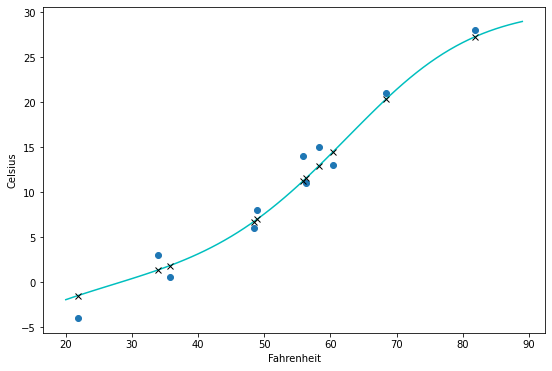

In [24]:
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(figsize=(9,6))
plt.xlabel("Fahrenheit") 
plt.ylabel("Celsius") 
plt.plot(t_u.numpy(), t_c.numpy(), 'o') 
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') 
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx');

The result is shown in `figure 6.9`. We can appreciate that the neural network has a tendency to overfit, as we discussed in `chapter 5`, since it tries to chase the measurements, including the noisy ones. Even our tiny neural network has too many parameters to fit the few measurements we have. It doesn’t do a bad job, though, overall.


## 6.4 Conclusion
We’ve covered a lot in `chapters 5` and `6`, although we have been dealing with a very simple problem. We dissected building differentiable models and training them using gradient descent, first using raw `autograd` and then relying on `nn`. By now you should have confidence in your understanding of what’s going on behind the scenes. Hopefully this taste of `PyTorch` has given you an appetite for more!

## 6.5 Exercises
[skip]

## 6.6 Summary
+ Neural networks can be automatically adapted to specialize themselves on the problem at hand.

+ Neural networks allow easy access to the analytical derivatives of the loss with respect to any parameter in the model, which makes evolving the parameters very efficient. Thanks to its automated differentiation engine, `PyTorch` provides such derivatives effortlessly.

+ Activation functions around linear transformations make neural networks capable of approximating highly nonlinear functions, at the same time keeping them simple enough to optimize.

+ The `nn` module together with the tensor standard library provide all the building blocks for creating neural networks.

+ To recognize overfitting, it’s essential to maintain the training set of data points separate from the validation set. There’s no one recipe to combat overfitting, but getting more data, or more variability in the data, and resorting to simpler models are good starts.

+ Anyone doing data science should be plotting data all the time.